In [1]:
import numpy as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
import matplotlib         as mpl
import matplotlib.pyplot  as plt
from mpl_toolkits.mplot3d import Axes3D
from invisible_cities.io import mcinfo_io as mio
from scipy import stats
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [2]:
def plot_3d_hits(hits, predicted_event, value='energy', coords = ['x', 'y', 'z'], cmap = mpl.cm.jet):
    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=hits.loc[:, value].min(), vmax=hits.loc[:, value].max())
    
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    colors = np.asarray(np.vectorize(m.to_rgba)(hits.loc[:, value]))
    colors = np.rollaxis(colors, 0, 2)

    ax.scatter(hits[coords[0]], hits[coords[1]], hits[coords[2]], c=colors, marker='o')
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')
    
    
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    cb.set_label (value)
    
    evt_type = "BG"
    if(predicted_event.label.values[0] == 1): evt_type = "SIGNAL"
    ax.set_title(f"Event {original_event.dataset_id.values[0]}, {hits.loc[:, value].sum():.3f} MeV: {evt_type}; ({predicted_event.class_0.values[0]*100:.1f}% BG, {predicted_event.class_1.values[0]*100:.1f}% SIGNAL)")

    plt.show()

In [3]:
def read_event(fname, datid, table='Voxels', group='DATASET'):
    with tb.open_file(fname) as h5in:
        return pd.DataFrame.from_records(h5in.root[group][table].read_where('dataset_id==datid'))

## Plotting events from dataset

In [4]:
# Esmeralda 15x15x10
original_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda_15x15x10/MC_NEXT100_Esmeralda_15x15x10_test.h5'
prediction_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda_15x15x10/tst_file_NEXT100_Esmeralda_15x15x10.h5'

# Esmeralda 2x2x2
#original_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda_2x2x2/MC_NEXT100_Esmeralda_2x2x2_test.h5'
#prediction_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda_2x2x2/tst_file_NEXT100_Esmeralda_2x2x2.h5'

# Esmeralda 5x5x10
#original_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda/MC_NEXT100_CHIT_test.h5'
#prediction_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda/tst_file_NEXT100_Esmeralda_epoch38.h5'

In [5]:
dataset_id = 0
original_event = read_event(original_dataset, dataset_id, table='Voxels') 
predicted_event = read_event(prediction_dataset, dataset_id, table='EventPred') 

In [6]:
original_event.head()

,xbin,ybin,zbin,energy,segclass,binclass,dataset_id
0,21,41,94,0.032974,-1,1,0
1,15,37,114,0.248948,-1,1,0
2,15,39,114,0.214897,-1,1,0
3,14,37,114,0.012224,-1,1,0
4,16,37,114,0.006986,-1,1,0


In [7]:
predicted_event.head()

,label,dataset_id,class_0,class_1
0,1,0,0.204267,0.795733


In [8]:
#add maxprediction to predicted_event
predicted_event = predicted_event.assign(pred = np.argmax(predicted_event[['class_0', 'class_1']].values, axis=-1))

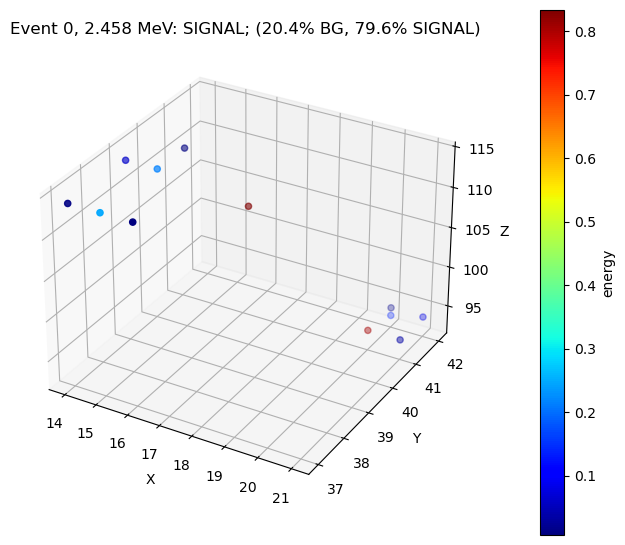

In [9]:
plot_3d_hits(original_event, predicted_event, coords = ['xbin', 'ybin', 'zbin'], cmap = mpl.cm.jet)

### Check energies of some events

In [10]:
f_original = tb.open_file(original_dataset)
df_voxels = pd.DataFrame.from_records(f_original.root['DATASET']['Voxels'][0:20000])

In [11]:
df_voxels.groupby('dataset_id')['energy'].sum().reset_index()

,dataset_id,energy
0,0,2.458403
1,1,2.461239
2,2,2.476716
3,3,2.460077
4,4,2.461031
...,...,...
731,731,2.447274
732,732,2.543033
733,733,2.501985
734,734,2.524977


## Analysis of training results

In [12]:
# Function to load data from HDF5 file
def load_data(filename):
    with tb.open_file(filename, 'r') as h5file:
        data = h5file.root.DATASET.EventPred[:]
        true_labels = data['label']
        probabilities_signal = data['class_1']
        probabilities_background = data['class_0']
    return true_labels, probabilities_signal, probabilities_background

# Function to plot the ROC curve and calculate AUC
def plot_roc_curve(true_labels, probabilities_signal):
    fpr, tpr, _ = roc_curve(true_labels, probabilities_signal)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot probability distributions
def plot_probability_distributions(true_labels, probabilities_signal):
    plt.figure()
    plt.hist(probabilities_signal[true_labels == 1], bins=50, alpha=0.5, label='Signal (True Label = 1)')
    plt.hist(probabilities_signal[true_labels == 0], bins=50, alpha=0.5, label='Background (True Label = 0)')
    plt.xlabel('Predicted Probability for Signal')
    plt.ylabel('Number of Events')
    #plt.title('Probability Distribution for Signal and Background')
    plt.legend(loc='upper right')
    plt.show()

# Function to display confusion matrix at a given threshold
def plot_confusion_matrix(true_labels, probabilities_signal, threshold=0.5):
    predicted_labels = (probabilities_signal >= threshold).astype(int)
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background', 'Signal'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Threshold = {threshold})')
    plt.show()

# Main function to run the analysis
def analyze_results(filename):
    true_labels, probabilities_signal, probabilities_background = load_data(filename)

    # Plot ROC curve and calculate AUC
    plot_roc_curve(true_labels, probabilities_signal)

    # Plot the probability distributions of signal and background
    plot_probability_distributions(true_labels, probabilities_signal)

    # Plot confusion matrix at default threshold 0.5
    plot_confusion_matrix(true_labels, probabilities_signal, threshold=0.5)

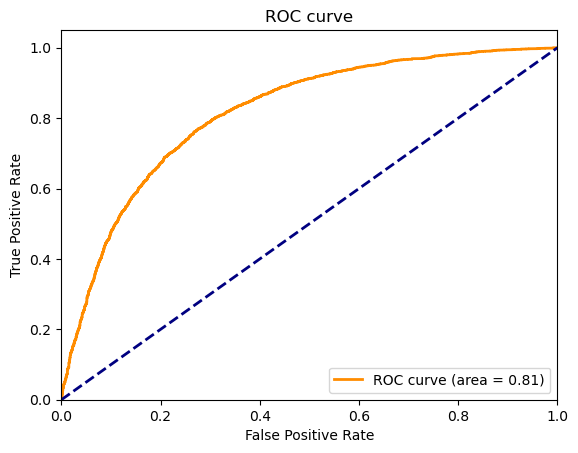

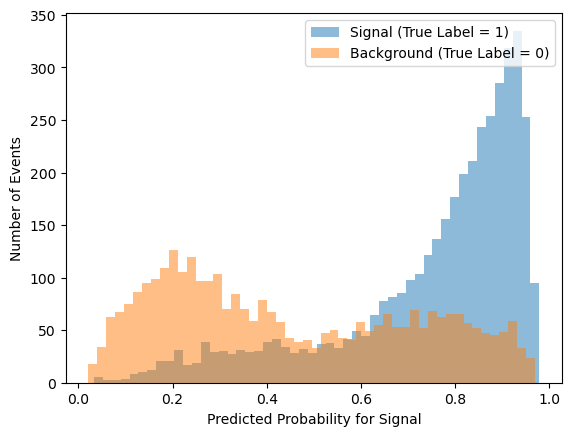

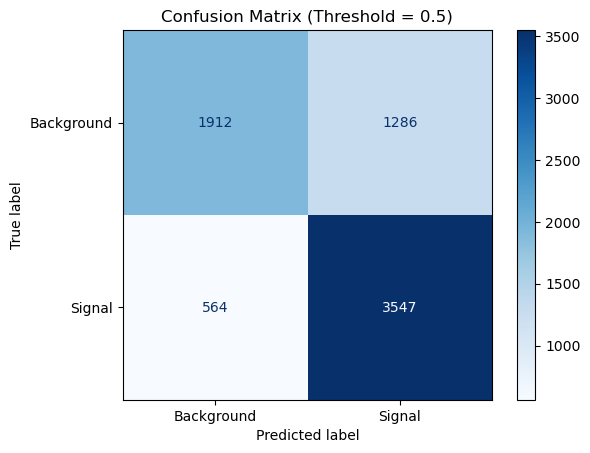

In [13]:
analyze_results(prediction_dataset)